In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import ClassificationDNN
from bbb.models.bnn import ClassificationBNN
from bbb.data import load_mnist, load_adverserial_mnist
from bbb.models.layers import BaseBFC

from evaluate_classifier import evaluate_classifier

from model_details import MODEL_DETAILS_DICT, load_model

from labellines import labelLines

In [9]:
matplotlib.style.use('default')
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [10]:
MODEL = "bnn_sgp_600_1200"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]
net, params = load_model(MODEL)

MODEL_DETAILS

ModelDetails(dir='../saved_models/BBB_classification/baseline/single_gaussian_prior/600_epochs/1200/2022-03-27-20.30.22', mclass=<class 'bbb.models.bnn.ClassificationBNN'>, description='BNN - 1200 hidden units, SGP, 600 epochs')

In [12]:
# Load data
path = "../data/adversarial_mnist/"
data = {}
eps = [0, 0.05, 0.1, 0.25]
for e in eps:
    data[e] = load_adverserial_mnist(train=False, size=8*params.batch_size, batch_size=params.batch_size, shuffle=True, randomise=True, epsilon=e)

In [13]:
# net = MODEL_DETAILS.mclass(params=params, eval_mode=True).to(DEVICE)
net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

2022-03-28 13:43:04,292 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,292 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,302 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,302 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,303 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,303 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


<All keys matched successfully>

In [29]:
results = {}

for MODEL in MODEL_DETAILS_DICT.keys():
    results[MODEL] = {}
    
for MODEL in MODEL_DETAILS_DICT.keys():
    print(f"-- {MODEL} --")
    net, params = load_model(MODEL)

    results[MODEL]['scores'] = []

    for eps in data.keys():
        eval_dict = evaluate_classifier(net, data[eps])
        
        score = float(eval_dict['eval_score'].numpy())
        eval_dict['eval_score'] = score 
        results[MODEL]['scores'].append(score)
        
        print(f"Eps {eps:<03.2f}: \t{round(eval_dict['eval_score'],4):>3}")

        results[MODEL][eps] = eval_dict

2022-03-28 13:56:36,315 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:36,315 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:36,325 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:36,326 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:36,327 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:36,327 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


-- bnn_sgp_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9746
Eps 0.10: 	0.791


2022-03-28 13:56:56,420 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:56,420 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:56,425 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:56,426 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:56,427 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:56:56,427 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


Eps 0.25: 	0.0713
-- bnn_sgp_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9717
Eps 0.10: 	0.7686


2022-03-28 13:57:09,124 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:09,125 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:09,127 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:09,127 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:09,128 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:09,128 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


Eps 0.25: 	0.0586
-- bnn_sgp_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9746
Eps 0.10: 	0.7578


2022-03-28 13:57:14,695 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:14,696 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:14,705 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:14,706 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:14,707 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:57:14,707 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


Eps 0.25: 	0.0615
-- bnn_sgp_600_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9805
Eps 0.10: 	0.8486


2022-03-28 13:57:34,665 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:57:34,665 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:57:34,675 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:57:34,675 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:57:34,676 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:57:34,677 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.1152
-- bnn_mog_600_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9805
Eps 0.10: 	0.8438


2022-03-28 13:58:04,025 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:04,025 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:04,036 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:04,036 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:04,038 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:04,038 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.1191
-- bnn_mog_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9893
Eps 0.10: 	0.7969


2022-03-28 13:58:33,698 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:33,699 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:33,704 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:33,704 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:33,706 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:33,706 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.082
-- bnn_mog_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9688
Eps 0.10: 	0.7471


2022-03-28 13:58:52,945 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:52,945 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:52,947 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:52,948 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:52,949 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-28 13:58:52,949 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.0547
-- bnn_mog_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9756
Eps 0.10: 	0.79
Eps 0.25: 	0.084
-- dnn_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.8643
Eps 0.10: 	0.46
Eps 0.25: 	0.0127
-- dnn_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.8262
Eps 0.10: 	0.3818
Eps 0.25: 	0.0068
-- dnn_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.7979
Eps 0.10: 	0.3662
Eps 0.25: 	0.0088
-- dnn_do_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.916
Eps 0.10: 	0.541
Eps 0.25: 	0.0117
-- dnn_do_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9092
Eps 0.10: 	0.499
Eps 0.25: 	0.0117
-- dnn_do_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.873
Eps 0.10: 	0.4414
Eps 0.25: 	0.0088


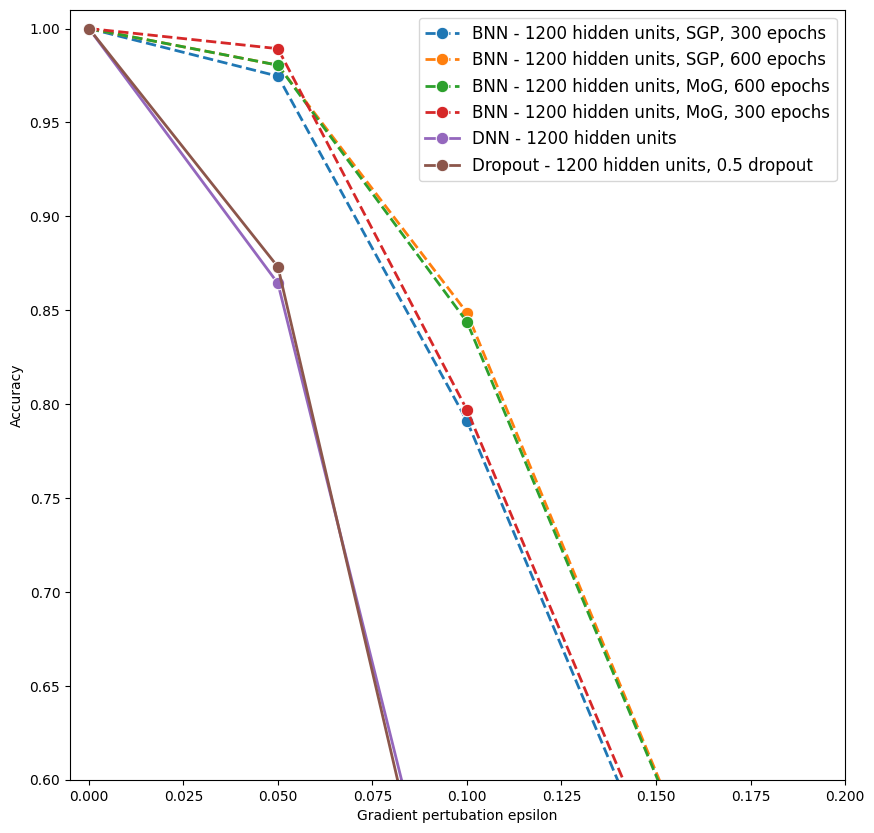

In [82]:
save_dir = "../plots/classification/adversarial"
labels = [0, 0.05, 0.1, 0.25]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
lw = 2
num_hidden_units = 1200
for idx, model in enumerate([x for x in results.keys() if x.__contains__(str(num_hidden_units))]):

    description = MODEL_DETAILS_DICT[model].description
    scores = results[model]['scores']

    lw = 2
    ms = 9

    if model.__contains__("bnn"):
        sns.lineplot(y=scores, x=labels, label=f"{description}", ax=ax, color=colors[idx],linestyle='--', linewidth=lw, marker="o", markersize=ms)
    else:
        sns.lineplot(y=scores, x=labels, label=f"{description}", ax=ax, color=colors[idx],linewidth=lw, marker="o", markersize=ms)

ax.legend()
ax.set_xlabel('Gradient pertubation epsilon')
ax.set(ylim=(0.60, 1.01), xlim=(-0.005, 0.20))
ax.set_ylabel('Accuracy')
ax.legend(loc='upper right', prop={'size': 12})


plt.savefig(os.path.join(save_dir, f'accuracy_eps_{num_hidden_units}_hidden_units_plot.png'), pad_inches=0.2, bbox_inches='tight')

plt.show()